In [1]:
DATADIR = './original' # unzipped train and test data
# Data Loading
import os
import re
from glob import glob
from tqdm import tqdm
import numpy as np

POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}

def load_data(data_dir):
    """ Return 2 lists of tuples:
    [(class_id, user_id, path), ...] for train
    [(class_id, user_id, path), ...] for validation
    """
    # Just a simple regexp for paths with three groups:
    # prefix, label, user_id
    pattern = re.compile("(.+\/)?(\w+)\/([^_]+)_.+wav")
    all_files = glob(os.path.join(data_dir, 'train/audio/*/*wav'))

    with open(os.path.join(data_dir, 'train/validation_list.txt'), 'r') as fin:
        validation_files = fin.readlines()
    valset = set()
    for entry in validation_files:
        r = re.match(pattern, entry)
        if r:
            valset.add(r.group(3))

    possible = set(POSSIBLE_LABELS)
    train, val = [], []
    for entry in all_files:
        r = re.match(pattern, entry)
        if r:
            label, uid = r.group(2), r.group(3)
            if label == '_background_noise_':
                label = 'silence'
            if label not in possible:
                label = 'unknown'

            label_id = name2id[label]

            sample = (label_id, uid, entry)
            if uid in valset:
                val.append(sample)
            else:
                train.append(sample)

    print('There are {} train and {} val samples'.format(len(train), len(val)))
    return train, val

trainset, valset = load_data(DATADIR)

There are 57929 train and 6798 val samples


In [2]:
import pandas as pd

trainset_filelist = pd.DataFrame([row[2] for row in trainset])
trainset_filelist.to_csv('./yaafe/trainset_list.txt', header=False, index=False)

valset_filelist = pd.DataFrame([row[2] for row in valset])
valset_filelist.to_csv('./yaafe/valset_list.txt', header=False, index=False)

feature_plan_file = './yaafe/feature_plan.txt'

def yaafeFile(filename):
    os.environ['FILENAME'] = filename
    os.environ['FEATURE_PLAN_FILENAME'] = feature_plan_file
    !yaafe -r 16000 ${FILENAME} -c ${FEATURE_PLAN_FILENAME}  -b ./yaafe/output

def yaafeFileList(input_list):
    os.environ['INPUT_LIST'] = input_list
    os.environ['FEATURE_PLAN_FILENAME'] = feature_plan_file
    !yaafe -r 16000 -i ${INPUT_LIST} -c ${FEATURE_PLAN_FILENAME}  -b ./yaafe/output
    
def plotYaafeFeatures(filename, yaafe_features):
    for feature_name, feature_desc in yaafe_features.items():
        df_feature = pd.read_csv('./yaafe/output' + filename[1:] + \
                                 '.' + feature_name + '.csv', skiprows=5, header=None)
        plt.figure()
        sns.heatmap(df_feature)
        plt.title(feature_desc)

feature_plan = pd.read_csv(feature_plan_file, sep=':', header = None)
yaafe_features = dict(zip(list(feature_plan[0]), list(feature_plan[1])))
yaafe_features

{'am': ' AmplitudeModulation blockSize=512 stepSize=256',
 'lpc': ' LPC LPCNbCoeffs=3',
 'lx': ' Loudness',
 'mfcc': ' MFCC blockSize=512 stepSize=256 CepsNbCoeffs=11',
 'obsi': ' OBSI',
 'obsir': ' OBSIR',
 'psh': ' PerceptualSharpness',
 'psp': ' PerceptualSpread',
 'sd': ' SpectralDecrease',
 'sf': ' SpectralFlatness',
 'ss': ' SpectralSlope',
 'sss': ' SpectralShapeStatistics',
 'sv': ' SpectralVariation'}

In [3]:
#yaafeFileList('./yaafe/trainset_list.txt')
#yaafeFileList('./yaafe/valset_list.txt')
#yaafeFileList('./yaafe/testset_list.txt')

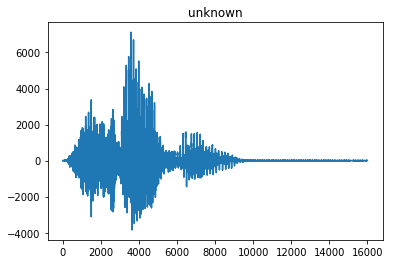

In [4]:
from scipy.io import wavfile
import IPython.display as ipd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

row = 2000

file_to_test = trainset[row][2] 
file_label = id2name[trainset[row][0]]
sample_rate, samples = wavfile.read(file_to_test)
plt.plot(samples)
plt.title(file_label)
ipd.Audio(samples, rate=sample_rate)

In [5]:
def getFlatFeaturesFromYaafeOutput(filename, yaafe_features):
    all_features_array = np.array([])
    for feature_name, feature_desc in yaafe_features.items():
        df_feature = pd.read_csv('./yaafe/output' + filename[1:] + '.' + \
                                 feature_name + '.csv', skiprows=5, header=None)
        feature_array = df_feature.as_matrix().ravel()
        feature_array = feature_array / (np.max(feature_array) + 0.00001)      
        all_features_array = np.append(all_features_array, feature_array)
    return all_features_array

def loadYaafeOutputToDF_Train(input_files):
    count_dict = {} 
    df = getFlatFeaturesFromYaafeOutput(input_files.loc[1, 2], yaafe_features)
    labels = [input_files.loc[1, 0]]
    for row in tqdm(range(2, len(input_files))):
        filename = input_files.loc[row, 2]
        label = input_files.loc[row, 0]
        features = getFlatFeaturesFromYaafeOutput(filename, yaafe_features)
        if len(features) == 2925:
            df = np.vstack([df, features])
            labels.append(label)
        else:
            count_dict[label] = count_dict.get(label, 0) + 1 
    return df

def loadYaafeOutputToDF_Validation(input_files):
    count_dict = {}
    df = getFlatFeaturesFromYaafeOutput(input_files.loc[0, 2], yaafe_features)
    labels = [input_files.loc[0, 0]]
    for row in tqdm(range(1, len(input_files))):
        filename = input_files.loc[row, 2]
        label = input_files.loc[row, 0]
        features = getFlatFeaturesFromYaafeOutput(filename, yaafe_features)
        if len(features) == 2925:
            df = np.vstack([df, features])
            labels.append(label)
        else:
            #print(str(label) +  ":" + str(len(features)))
            count_dict[label] = count_dict.get(label, 0) + 1 
    return df

def loadYaafeOutputToDF_Test(input_files): 
    df = getFlatFeaturesFromYaafeOutput(input_files.loc[0, 0], yaafe_features)
    for row in tqdm(range(1, len(input_files))):
        filename = input_files.loc[row, 0]
        features = getFlatFeaturesFromYaafeOutput(filename, yaafe_features)
        if len(features) == 2925:
            df = np.vstack([df, features])
        else:
            print(str(len(features)))
            df = np.vstack([df, np.zeros(2925)])
    return df

def load_test_data(data_dir):
    pattern = re.compile("(.+\/)?(\w+)\/([^_]+)_.+wav")
    all_files = glob(os.path.join(data_dir, 'test/audio/*'))
    testset = []
    for entry in all_files:
        r = re.match(pattern, entry)
        if r:
            testset.append(r.group(0))
    return testset

In [8]:
import pandas as pd
from glob import glob
from tqdm import tqdm
import os

testset = load_test_data('./original')

for high in range(1000, 160000, 1000): #160000 158538
    low = high - 1000
    df_test = loadYaafeOutputToDF_Test(pd.DataFrame(testset[low:high]))
    filenames = [path.split('/')[-1] for path in testset[low:high]]
    df_test = pd.DataFrame(df_test)
    df_test['fname'] = filenames
    df_test.to_csv('./yaafe/test/test_' + str(high) +'.csv', index=False)
    #print(str(low) + ':' + str(df_test.shape))

100%|██████████| 537/537 [00:05<00:00, 90.53it/s]


In [7]:
df_fromfile = pd.read_csv('./yaafe/test/test_2000.csv')